Submitted by:  
Saurabh Kumar  
SC22B146

[The final submission will omit the dataset to reduce the upload size.]

# Building a Visual Words Dictionary

In this assignment, we will implement a Visual Words Dictionary using the Bag of Visual Words (BoVW) approach, a fundamental technique in traditional computer vision for image classification and retrieval.

The assignment is structured in three main sections:
1. Extract Filter Responses - Apply various filters to extract features from images
2. Collect Sample Points - Sample points from the filtered responses
3. Compute Dictionary - Use clustering to create a dictionary of visual words

Complete the functions marked with TODO comments.

DATASET: You'll work with the Caltech-101 dataset. A subset is provided with the assignment.

https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
from tqdm import tqdm
import pickle
from typing import List, Tuple, Dict, Any

In [67]:
def load_images(directory: str, max_images: int = 100) -> List[np.ndarray]:
    """
    Load images from the specified directory.
    
    Args:
        directory: Path to directory containing images
        max_images: Maximum number of images to load
        
    Returns:
        List of loaded images as numpy arrays
    """
    images = []
    count = 0

    for root, _, files in os.walk(directory):
        for filename in files:
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(root, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (256, 256))  # Optional resize
                    images.append(img)
                    count += 1
                    if count >= max_images:
                        print(f"Loaded {len(images)} images")
                        return images
                        
    print(f"Loaded {len(images)} images")
    return images

### PART 1: Extract Filter Responses

In [4]:
def extract_filter_responses(image: np.ndarray) -> np.ndarray:
    """
    Extract filter responses from an image using various filters.
    
    You should implement at least:
    - Gaussian filters at multiple scales
    - Laplacian of Gaussian (LoG) filters
    - Gabor filters at multiple orientations
    
    Args:
        image: Input image (RGB)
        
    Returns:
        Filter responses as a numpy array of shape (H, W, D) where D is the number of filter responses
    """
    # Convert to grayscale for filtering
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()
    
    # TODO: Implement filter response extraction
    # 1. Apply Gaussian filters at multiple scales
    # 2. Apply Laplacian of Gaussian (LoG) filters
    # 3. Apply Gabor filters at multiple orientations
    # 4. Combine all filter responses into a single feature vector for each pixel
    
    # Example (you need to complete this):
    responses = []
    
    # Gaussian filters at multiple scales
    # TODO: Implement Gaussian filtering at different sigma values
    sigmas = [1, 2, 4]
    for sigma in sigmas:
        responses.append(cv2.GaussianBlur(gray, (0, 0), sigma))
    
    # Laplacian of Gaussian
    # TODO: Implement LoG filtering at different sigma values
    for sigma in sigmas:
        blur = cv2.GaussianBlur(gray, (0, 0), sigma)
        log = cv2.Laplacian(blur, cv2.CV_64F)
        responses.append(log)
    
    # Gabor filters
    # TODO: Implement Gabor filtering at different orientations and scales
    thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    lambdas = [10, 20]
    for theta in thetas:
        for lambd in lambdas:
            gabor_kernel = cv2.getGaborKernel((21, 21), 4.0, theta, lambd, 0.5, 0, ktype=cv2.CV_64F)
            gabor_response = cv2.filter2D(gray, cv2.CV_64F, gabor_kernel)
            responses.append(gabor_response)
    
    # Stack all responses
    if not responses:
        # Placeholder - replace this with your implementation
        responses = [gray]
    
    filter_responses = np.dstack(responses)
    
    return filter_responses

### PART 2: Collect Sample Points

In [11]:
def collect_sample_points(filter_responses: List[np.ndarray], points_per_image: int = 1000, 
                          sampling_method: str = 'random') -> np.ndarray:
    """
    Collect sample points from filter responses.
    
    Args:
        filter_responses: List of filter responses for multiple images
        points_per_image: Number of points to sample per image
        sampling_method: Method for sampling ('random', 'dense', or 'interest')
        
    Returns:
        Array of sampled points with shape (N, D) where N is the total number of samples
        and D is the dimensionality of the filter responses
    """
    # TODO: Implement point sampling
    # Choose between:
    # 1. Random sampling
    # 2. Dense sampling (regular grid)
    # 3. Interest point detection (e.g., using Harris corner detector)
    
    all_samples = []
    
    for response in filter_responses:
        h, w, d = response.shape
        
        if sampling_method == 'random':
            # TODO: Implement random sampling
            # Hint: Use np.random.randint to generate random coordinates
            ys = np.random.randint(0, h, points_per_image)
            xs = np.random.randint(0, w, points_per_image)
            
        elif sampling_method == 'dense':
            # TODO: Implement dense grid sampling
            # Sample points on a regular grid
            step = int(np.sqrt((h * w) / points_per_image))
            ys, xs = np.meshgrid(np.arange(0, h, step), np.arange(0, w, step), indexing='ij')
            ys, xs = ys.flatten(), xs.flatten()
            idx = np.random.choice(len(ys), size=min(points_per_image, len(ys)), replace=False)
            ys, xs = ys[idx], xs[idx]
            
        elif sampling_method == 'interest':
            # TODO: Implement interest point sampling
            # Use a detector like Harris corner detector to find interesting points
            corners = cv2.goodFeaturesToTrack(cv2.normalize(response[:, :, 0], None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8), maxCorners=points_per_image, qualityLevel=0.01, minDistance=5)

            if corners is not None:
                coords = corners.squeeze().astype(int)
                xs, ys = coords[:, 0], coords[:, 1]
            else:
                ys = np.random.randint(0, h, points_per_image)
                xs = np.random.randint(0, w, points_per_image)
            
        else:
            raise ValueError(f"Unknown sampling method: {sampling_method}")
        
        # Placeholder - replace with your implementation
        # samples = np.random.rand(points_per_image, d)
        samples = response[ys, xs]
        all_samples.append(samples)
    
    return np.vstack(all_samples)


### PART 3: Compute Dictionary of Visual Words

In [14]:
from sklearn.preprocessing import StandardScaler

def compute_dictionary(samples: np.ndarray, num_words: int = 200) -> np.ndarray:
    """
    Compute dictionary of visual words using K-means clustering.
    
    Args:
        samples: Sampled points from filter responses with shape (N, D)
        num_words: Number of visual words (clusters) to create
        
    Returns:
        Dictionary of visual words with shape (num_words, D)
    """
    # TODO: Implement K-means clustering to create visual words
    # 1. Normalize the samples (optional but recommended)
    # 2. Run K-means clustering
    # 3. Return the cluster centers as the visual words dictionary
    
    # Example (you need to complete this):
    # Normalize samples (optional)
    # samples_normalized = ...
    scaler = StandardScaler()
    samples_normalized = scaler.fit_transform(samples)

    
    # Run K-means
    # kmeans = KMeans(n_clusters=num_words, random_state=42)
    # kmeans.fit(samples_normalized)
    # dictionary = kmeans.cluster_centers_
    kmeans = KMeans(n_clusters=num_words, random_state=42, n_init=10)
    kmeans.fit(samples_normalized)

    # Placeholder - replace with your implementation
    # dictionary = np.random.rand(num_words, samples.shape[1])
    dictionary = kmeans.cluster_centers_
    
    return dictionary

### Helper function to visualize the dictionary

In [69]:
def visualize_dictionary(dictionary: np.ndarray, filter_size: int = 8) -> None:
    """
    Visualize the dictionary of visual words.
    
    Args:
        dictionary: Dictionary of visual words
        filter_size: Size of each filter to display
    """
    # TODO: Implement visualization of the visual words dictionary
    # Hint: Reshape each visual word to the size of the filters and display them in a grid
    
    num_words = dictionary.shape[0]
    num_cols = 10
    num_rows = int(np.ceil(num_words / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 2 * num_rows))
    for i in range(num_rows * num_cols):
        ax = axes[i // num_cols, i % num_cols]
        if i < num_words:
            ax.bar(range(dictionary.shape[1]), dictionary[i])
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

### Function to encode an image using the dictionary

In [ ]:
from sklearn.metrics import pairwise_distances_argmin

def encode_image(image: np.ndarray, dictionary: np.ndarray) -> np.ndarray:
    """
    Encode an image using the dictionary of visual words.
    
    Args:
        image: Input image
        dictionary: Dictionary of visual words
        
    Returns:
        Histogram of visual words (Bag of Visual Words representation)
    """
    # TODO: Implement image encoding using the dictionary
    # 1. Extract filter responses from the image
    # 2. Assign each pixel's filter response to the nearest visual word
    # 3. Create a histogram of visual word occurrences
    
    # Extract filter responses
    filter_responses = extract_filter_responses(image)
    
    # Reshape filter responses to (H*W, D)
    h, w, d = filter_responses.shape
    responses_reshaped = filter_responses.reshape(-1, d)
    
    # Assign each response to the nearest visual word
    # TODO: Implement nearest neighbor assignment
    # Hint: Use np.linalg.norm or sklearn's pairwise_distances
    word_indices = pairwise_distances_argmin(responses_reshaped, dictionary)
    
    # Create histogram
    # TODO: Implement histogram creation
    # hist = np.zeros(len(dictionary))
    # ...
    
    # Placeholder - replace with your implementation
    # hist = np.random.rand(len(dictionary))
    hist, _ = np.histogram(word_indices, bins=np.arange(len(dictionary) + 1))
    hist = hist.astype(float)
    hist = hist / np.sum(hist)  # Normalize
    
    return hist

Main function to run the assignment.

Loaded 50 images
Extracting filter responses...


100%|██████████| 50/50 [00:01<00:00, 28.00it/s]


Computing dictionary...
Visualizing dictionary...


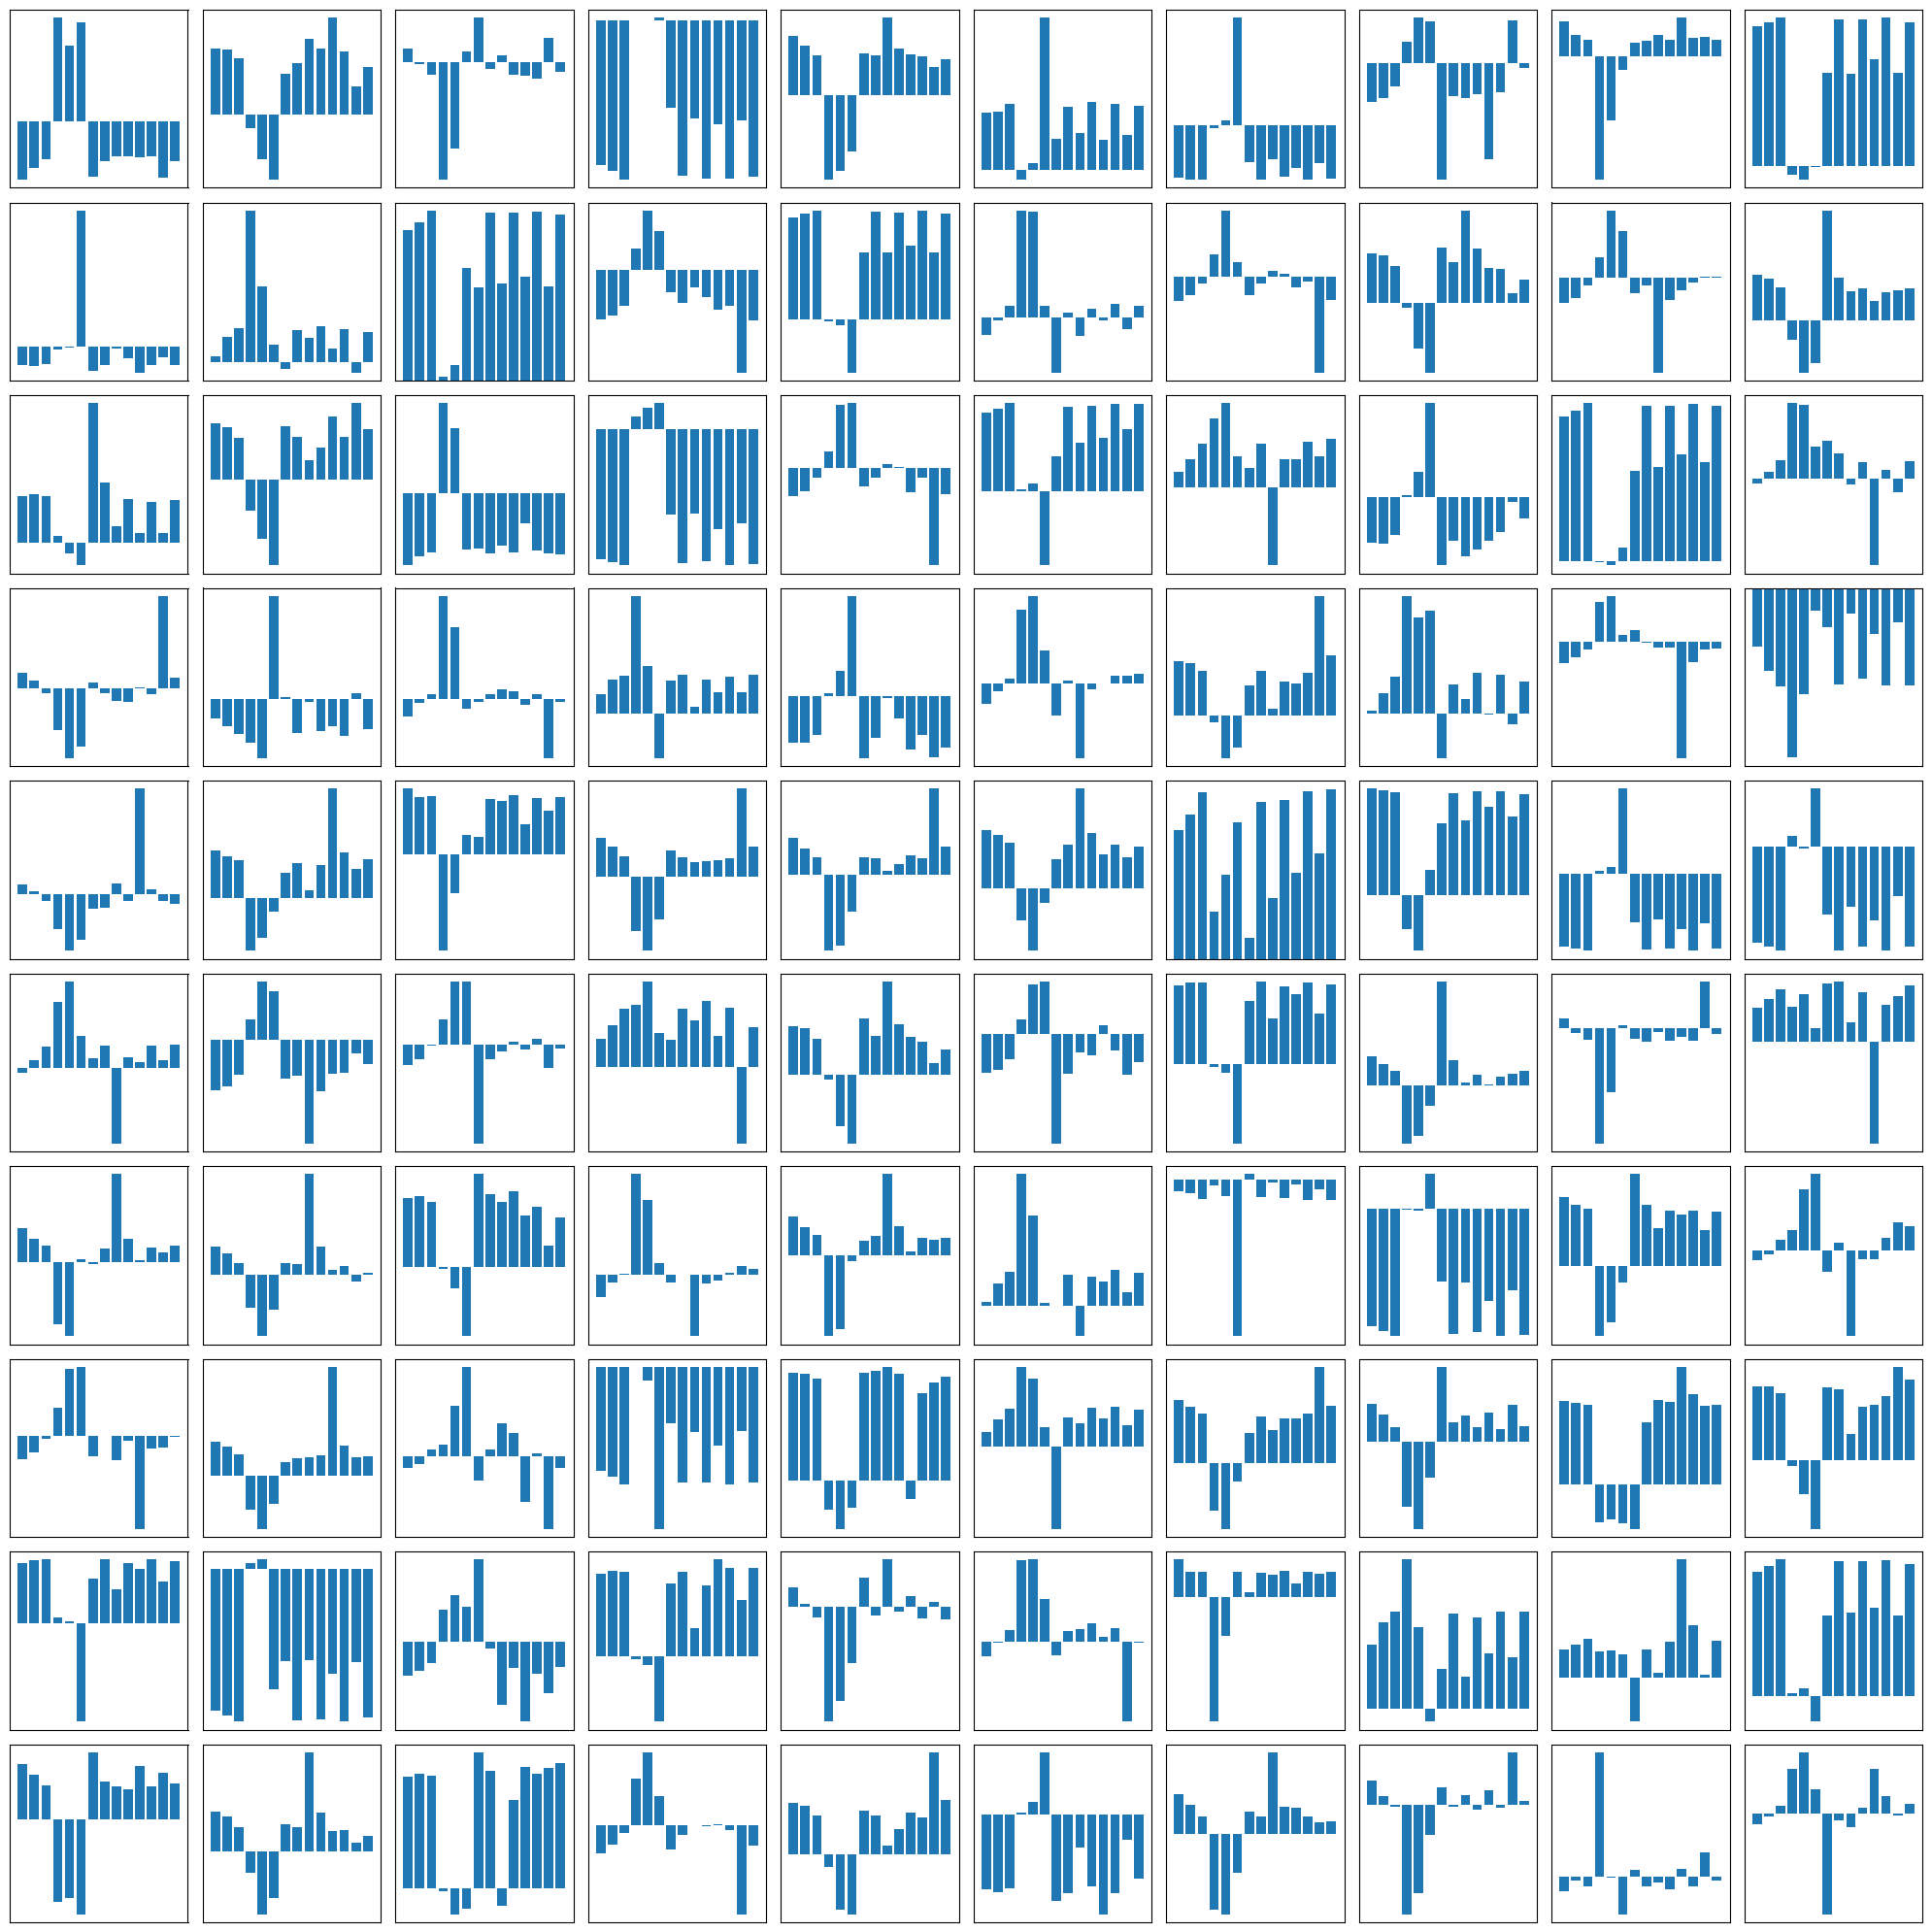

Encoding test images...


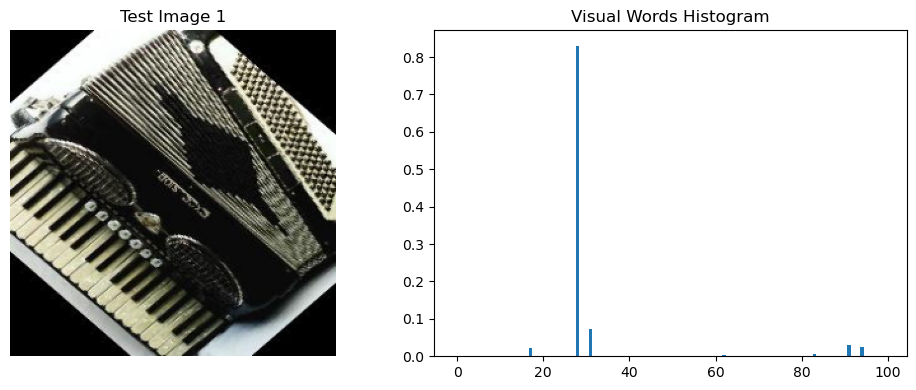

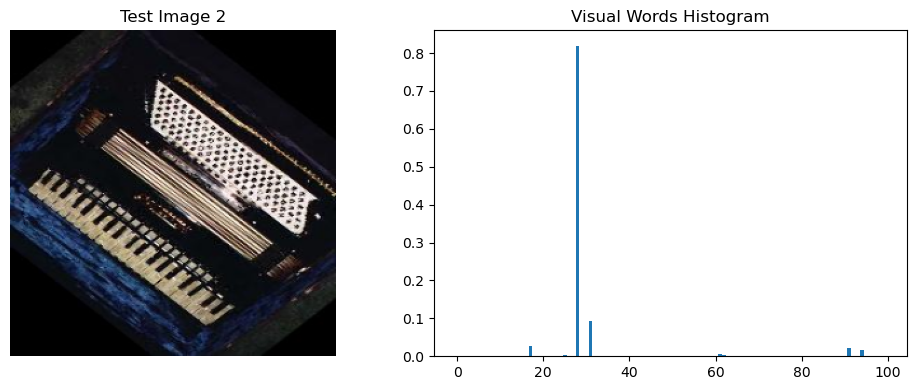

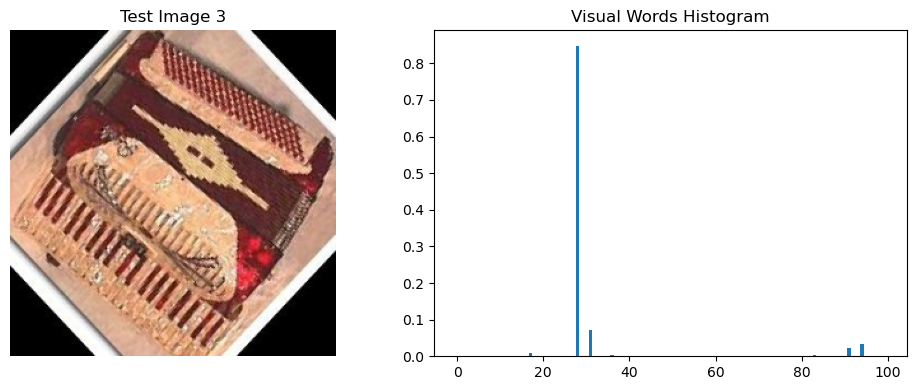

In [71]:
 # Load images
data_dir = "dataset/caltech-101/caltech-101/101_ObjectCategories"  
images = load_images(data_dir, max_images=50)

# Part 1: Extract filter responses
print("Extracting filter responses...")
filter_responses = [extract_filter_responses(img) for img in tqdm(images)]

# Part 2: Collect sample points
print("Collecting sample points...")
samples = collect_sample_points(filter_responses, points_per_image=500)

# Part 3: Compute dictionary
print("Computing dictionary...")
dictionary = compute_dictionary(samples, num_words=100)

# Visualize dictionary
print("Visualizing dictionary...")
visualize_dictionary(dictionary)

# Example: Encode some test images
print("Encoding test images...")
for i, img in enumerate(images[:3]):
    hist = encode_image(img, dictionary)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Test Image {i+1}")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.bar(range(len(hist)), hist)
    plt.title("Visual Words Histogram")
    plt.tight_layout()
    plt.show()

np.save("dictionary.npy", dictionary)

Run tests to verify the implementations.